# 2022 Qatar World Cup Analysis

## Importing packages

In [279]:
%matplotlib inline

import numpy as np
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotnine import *

## Loading, cleaning, and exploring datasets

We have two main datasets which we will be working with in our project; our main dataset is the `matches` dataset which contains information about the matches played in the 2022 Qatar World Cup. The second dataset, `countries`, relates to the individual country statistics, which we will be aggregating from our information about each match in order to get a better understanding of the teams and their performance.

In [280]:
matches = pd.read_csv('cup.csv')
matches.head()

,team1,team2,possession team1,possession team2,possession in contest,number of goals team1,number of goals team2,date,hour,category,...,penalties scored team1,penalties scored team2,goal preventions team1,goal preventions team2,own goals team1,own goals team2,forced turnovers team1,forced turnovers team2,defensive pressures applied team1,defensive pressures applied team2
0,QATAR,ECUADOR,42%,50%,8%,0,2,20 NOV 2022,17 : 00,Group A,...,0,1,6,5,0,0,52,72,256,279
1,ENGLAND,IRAN,72%,19%,9%,6,2,21 NOV 2022,14 : 00,Group B,...,0,1,8,13,0,0,63,72,139,416
2,SENEGAL,NETHERLANDS,44%,45%,11%,0,2,21 NOV 2022,17 : 00,Group A,...,0,0,9,15,0,0,63,73,263,251
3,UNITED STATES,WALES,51%,39%,10%,1,1,21 NOV 2022,20 : 00,Group B,...,0,1,7,7,0,0,81,72,242,292
4,ARGENTINA,SAUDI ARABIA,64%,24%,12%,1,2,22 NOV 2022,11 : 00,Group C,...,1,0,4,14,0,0,65,80,163,361


In [281]:
countries = pd.read_csv('precup_rank.csv', index_col='Nation')
countries.head()

,Rank,Points
Nation,,
Brazil,1,1841.30
Belgium,2,1816.71
Argentina,3,1773.88
France,4,1759.78
England,5,1728.47


In [282]:
# we are creating a lot of columns, and it doesn't look pretty, but this is what we want to do; is there a better way to do this?
# also, a problem that might arise is that it will become hard to distinguish actual zeroes from missing values, which we might need to research a better way for that as well
countries['Possession in Group'] = 0
countries['Possession in Round of 16'] = 0
countries['Possession in Quarter-final'] = 0
countries['Possession in Semi-final'] = 0
countries['Possession in Play-off for third place'] = 0
countries['Possession in Final'] = 0

countries['Total Passes in Group'] = 0
countries['Total Passes in Round of 16'] = 0
countries['Total Passes in Quarter-final'] = 0
countries['Total Passes in Semi-final'] = 0
countries['Total Passes in Play-off for third place'] = 0
countries['Total Passes in Final'] = 0

countries['Completed Passes in Group'] = 0
countries['Completed Passes in Round of 16'] = 0
countries['Completed Passes in Quarter-final'] = 0
countries['Completed Passes in Semi-final'] = 0
countries['Completed Passes in Play-off for third place'] = 0
countries['Completed Passes in Final'] = 0

countries['Shot Attempts in Group'] = 0
countries['Shot Attempts in Round of 16'] = 0
countries['Shot Attempts in Quarter-final'] = 0
countries['Shot Attempts in Semi-final'] = 0
countries['Shot Attempts in Play-off for third place'] = 0
countries['Shot Attempts in Final'] = 0

countries['Total Goals in Group'] = 0
countries['Total Goals in Round of 16'] = 0
countries['Total Goals in Quarter-final'] = 0
countries['Total Goals in Semi-final'] = 0
countries['Total Goals in Play-off for third place'] = 0
countries['Total Goals in Final'] = 0

countries['Close Range Goals in Group'] = 0
countries['Close Range Goals in Round of 16'] = 0
countries['Close Range Goals in Quarter-final'] = 0
countries['Close Range Goals in Semi-final'] = 0
countries['Close Range Goals in Play-off for third place'] = 0
countries['Close Range Goals in Final'] = 0

countries['Long Range Goals in Group'] = 0
countries['Long Range Goals in Round of 16'] = 0
countries['Long Range Goals in Quarter-final'] = 0
countries['Long Range Goals in Semi-final'] = 0
countries['Long Range Goals in Play-off for third place'] = 0
countries['Long Range Goals in Final'] = 0

countries['Conceded in Group'] = 0
countries['Conceded in Round of 16'] = 0
countries['Conceded in Quarter-final'] = 0
countries['Conceded in Semi-final'] = 0
countries['Conceded in Play-off for third place'] = 0
countries['Conceded in Final'] = 0

countries['Assists in Group'] = 0
countries['Assists in Round of 16'] = 0
countries['Assists in Quarter-final'] = 0
countries['Assists in Semi-final'] = 0
countries['Assists in Play-off for third place'] = 0
countries['Assists in Final'] = 0

countries['Fouls in Group'] = 0
countries['Fouls in Round of 16'] = 0
countries['Fouls in Quarter-final'] = 0
countries['Fouls in Semi-final'] = 0
countries['Fouls in Play-off for third place'] = 0
countries['Fouls in Final'] = 0

countries['Yellow Cards in Group'] = 0
countries['Yellow Cards in Round of 16'] = 0
countries['Yellow Cards in Quarter-final'] = 0
countries['Yellow Cards in Semi-final'] = 0
countries['Yellow Cards in Play-off for third place'] = 0
countries['Yellow Cards in Final'] = 0

countries['Red Cards in Group'] = 0
countries['Red Cards in Round of 16'] = 0
countries['Red Cards in Quarter-final'] = 0
countries['Red Cards in Semi-final'] = 0
countries['Red Cards in Play-off for third place'] = 0
countries['Red Cards in Final'] = 0

countries['Offsides in Group'] = 0
countries['Offsides in Round of 16'] = 0
countries['Offsides in Quarter-final'] = 0
countries['Offsides in Semi-final'] = 0
countries['Offsides in Play-off for third place'] = 0
countries['Offsides in Final'] = 0

countries['Saves in Group'] = 0
countries['Saves in Round of 16'] = 0
countries['Saves in Quarter-final'] = 0
countries['Saves in Semi-final'] = 0
countries['Saves in Play-off for third place'] = 0
countries['Saves in Final'] = 0

countries['Penalties in Group'] = 0
countries['Penalties in Round of 16'] = 0
countries['Penalties in Quarter-final'] = 0
countries['Penalties in Semi-final'] = 0
countries['Penalties in Play-off for third place'] = 0
countries['Penalties in Final'] = 0

countries['Free Kicks in Group'] = 0
countries['Free Kicks in Round of 16'] = 0
countries['Free Kicks in Quarter-final'] = 0
countries['Free Kicks in Semi-final'] = 0
countries['Free Kicks in Play-off for third place'] = 0
countries['Free Kicks in Final'] = 0

countries['Corners in Group'] = 0
countries['Corners in Round of 16'] = 0
countries['Corners in Quarter-final'] = 0
countries['Corners in Semi-final'] = 0
countries['Corners in Play-off for third place'] = 0
countries['Corners in Final'] = 0

countries['Own Goals in Group'] = 0
countries['Own Goals in Round of 16'] = 0
countries['Own Goals in Quarter-final'] = 0
countries['Own Goals in Semi-final'] = 0
countries['Own Goals in Play-off for third place'] = 0
countries['Own Goals in Final'] = 0

countries['Forced Turnovers in Group'] = 0
countries['Forced Turnovers in Round of 16'] = 0
countries['Forced Turnovers in Quarter-final'] = 0
countries['Forced Turnovers in Semi-final'] = 0
countries['Forced Turnovers in Play-off for third place'] = 0
countries['Forced Turnovers in Final'] = 0

countries['GroupID'] = ''

Now that we have our `countries` dataset prepared for data to enter it, we need to start to modify our `matches` dataset, so that any redundant information is discarded, and all the information we need is correctly represented.

In [283]:
# only take the team1 and team2 columns and drop the rest
matches = matches[[
    'team1',
    'team2',
    'possession team1',
    'possession team2',
    'possession in contest',
    'number of goals team1',
    'number of goals team2',
    'category',
    'total attempts team1',
    'total attempts team2',
    'conceded team1',
    'conceded team2',
    'goal inside the penalty area team1',
    'goal inside the penalty area team2',
    'goal outside the penalty area team1',
    'goal outside the penalty area team2',
    'assists team1',
    'assists team2',
    'yellow cards team1',
    'yellow cards team2',
    'red cards team1',
    'red cards team2',
    'fouls against team1',
    'fouls against team2',
    'offsides team1',
    'offsides team2',
    'passes team1',
    'passes team2',
    'passes completed team1',
    'passes completed team2',
    'crosses team1',
    'crosses team2',
    'crosses completed team1',
    'crosses completed team2',
    'corners team1',
    'corners team2',
    'free kicks team1',
    'free kicks team2',
    'penalties scored team1',
    'penalties scored team2',
    'goal preventions team1',
    'goal preventions team2',
    'own goals team1',
    'own goals team2',
    'forced turnovers team1',
    'forced turnovers team2'
]]

matches['team1'] = matches['team1'].str.title()
matches['team2'] = matches['team2'].str.title()

matches['GroupID'] = matches['category'].apply(lambda x: x[-1] if 'Group' in x else np.nan)
matches['category'] = matches['category'].apply(lambda x: x[:-2] if 'Group' in x else x)

matches['possession team1'] = matches['possession team1'].str[:-1].astype(int)
matches['possession team2'] = matches['possession team2'].str[:-1].astype(int)
matches['possession in contest'] = matches['possession in contest'].str[:-1].astype(int)

matches.head()

,team1,team2,possession team1,possession team2,possession in contest,number of goals team1,number of goals team2,category,total attempts team1,total attempts team2,...,free kicks team2,penalties scored team1,penalties scored team2,goal preventions team1,goal preventions team2,own goals team1,own goals team2,forced turnovers team1,forced turnovers team2,GroupID
0,Qatar,Ecuador,42,50,8,0,2,Group,5,6,...,17,0,1,6,5,0,0,52,72,A
1,England,Iran,72,19,9,6,2,Group,13,8,...,10,0,1,8,13,0,0,63,72,B
2,Senegal,Netherlands,44,45,11,0,2,Group,14,9,...,14,0,0,9,15,0,0,63,73,A
3,United States,Wales,51,39,10,1,1,Group,6,7,...,15,0,1,7,7,0,0,81,72,B
4,Argentina,Saudi Arabia,64,24,12,1,2,Group,14,3,...,16,1,0,4,14,0,0,65,80,C


In [284]:
matches['category'].unique()

array(['Group', 'Round of 16', 'Quarter-final', 'Semi-final',
       'Play-off for third place', 'Final'], dtype=object)

In [285]:
# dividing the data based on what stage of the tournament the match was in
groupMatches = matches.loc[matches['category'] == 'Group']
ro16 = matches.loc[matches['category'] == 'Round of 16']
quarterfinals = matches.loc[matches['category'] == 'Quarter-final']
semifinals = matches.loc[matches['category'] == 'Semi-final']
thirdPlaceMatch = matches.loc[matches['category'] == 'Play-off for third place']
final = matches.loc[matches['category'] == 'Final']

We are now going to write some code which will allow us to clean up the way some of this data looks. Ideally, we want to observe these statistics based on country, while we have it here as `team1` or `team2`, which isn't really helpful if we want to get a context of a particular country. So, using the `countries` dataset that we have introduced earlier that just contains their FIFA rank at the time of the World Cup, we will be adding each countries individual statistics to the dataset.

In [286]:

def parseRound(round):
    teamID = ''
    for team in countries.index:
        roundMatches = round.loc[((round['team1'] == team) | (round['team2'] == team))]
        for _, match in roundMatches.iterrows():

            if match['team1'] == team:
                teamID = '1'
            else:
                teamID = '2'

            if match['category'] == 'Group':
                countries.loc[team, f'GroupID'] = match[f'GroupID']

            #print(team, match[f'number of goals team{teamID}'])
            countries.loc[team, f'Possession in {match["category"]}'] += match[f'possession team{teamID}']
            countries.loc[team, f'Total Passes in {match["category"]}'] += match[f'passes team{teamID}']
            countries.loc[team, f'Completed Passes in {match["category"]}'] += match[f'passes completed team{teamID}']
            countries.loc[team, f'Total Goals in {match["category"]}'] += match[f'number of goals team{teamID}']
            countries.loc[team, f'Close Range Goals in {match["category"]}'] += match[f'goal inside the penalty area team{teamID}']
            countries.loc[team, f'Long Range Goals in {match["category"]}'] += match[f'goal outside the penalty area team{teamID}']
            countries.loc[team, f'Conceded in {match["category"]}'] += match[f'conceded team{teamID}']
            countries.loc[team, f'Assists in {match["category"]}'] += match[f'assists team{teamID}']
            countries.loc[team, f'Own Goals in {match["category"]}'] += match[f'own goals team{teamID}']
            countries.loc[team, f'Forced Turnovers in {match["category"]}'] += match[f'forced turnovers team{teamID}']
            countries.loc[team, f'Saves in {match["category"]}'] += match[f'goal preventions team{teamID}']
            countries.loc[team, f'Penalties in {match["category"]}'] += match[f'penalties scored team{teamID}']
            countries.loc[team, f'Free Kicks in {match["category"]}'] += match[f'free kicks team{teamID}']
            countries.loc[team, f'Corners in {match["category"]}'] += match[f'corners team{teamID}']
            countries.loc[team, f'Fouls in {match["category"]}'] += match[f'fouls against team{teamID}']
            countries.loc[team, f'Offsides in {match["category"]}'] += match[f'offsides team{teamID}']
            countries.loc[team, f'Yellow Cards in {match["category"]}'] += match[f'yellow cards team{teamID}']
            countries.loc[team, f'Red Cards in {match["category"]}'] += match[f'red cards team{teamID}']
            countries.loc[team, f'Shot Attempts in {match["category"]}'] += match[f'total attempts team{teamID}']


parseRound(groupMatches)
parseRound(ro16)
parseRound(quarterfinals)
parseRound(semifinals)
parseRound(thirdPlaceMatch)
parseRound(final)

In [287]:
countries['Average Possession in Group'] = round(countries['Possession in Group'] / 3, 2)
# create column called 'Goals Per Game' which is total goals in group stage divided by 3
countries['Goals Per Game in Group'] = round(countries['Total Goals in Group'] / 3, 2)
countries.head()

,Rank,Points,Possession in Group,Possession in Round of 16,Possession in Quarter-final,Possession in Semi-final,Possession in Play-off for third place,Possession in Final,Total Passes in Group,Total Passes in Round of 16,...,Own Goals in Final,Forced Turnovers in Group,Forced Turnovers in Round of 16,Forced Turnovers in Quarter-final,Forced Turnovers in Semi-final,Forced Turnovers in Play-off for third place,Forced Turnovers in Final,GroupID,Average Possession in Group,Goals Per Game in Group
Nation,,,,,,,,,,,,,,,,,,,,,
Brazil,1,1841.30,160,47,45,0,0,0,1698,616,...,0,211,73,77,0,0,0,G,53.33,1.00
Belgium,2,1816.71,149,0,0,0,0,0,1779,0,...,0,180,0,0,0,0,0,F,49.67,0.33
Argentina,3,1773.88,181,53,44,34,0,46,2005,711,...,0,176,67,79,85,0,87,C,60.33,1.67
France,4,1759.78,156,48,36,34,0,40,1873,540,...,0,223,71,54,72,0,104,D,52.00,2.00
England,5,1728.47,181,54,54,0,0,0,1947,597,...,0,171,60,49,0,0,0,B,60.33,3.00


## Visualizing the Group Stage

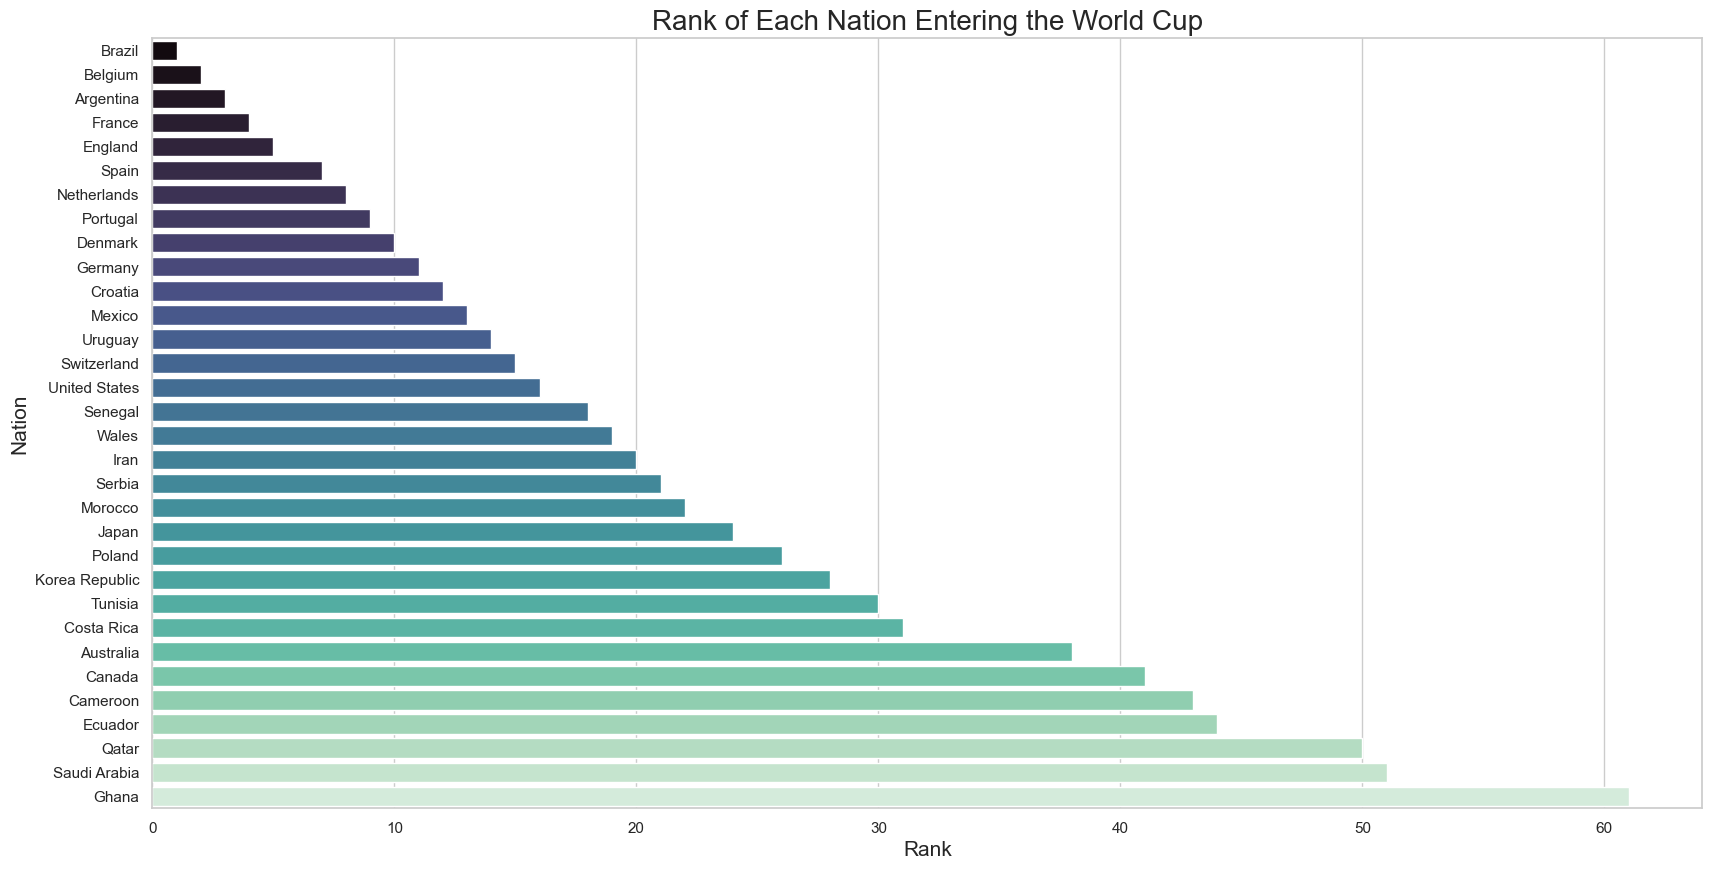

In [292]:
#visualizing the rank of each nation entering WC (better way to visualize this surely)
plt.figure(figsize=(20, 10))
sns.barplot(x=countries['Rank'], y=countries.index, palette='mako')
plt.title('Rank of Each Nation Entering the World Cup', fontsize=20)
plt.xlabel('Rank', fontsize=15)
plt.ylabel('Nation', fontsize=15)
plt.show()

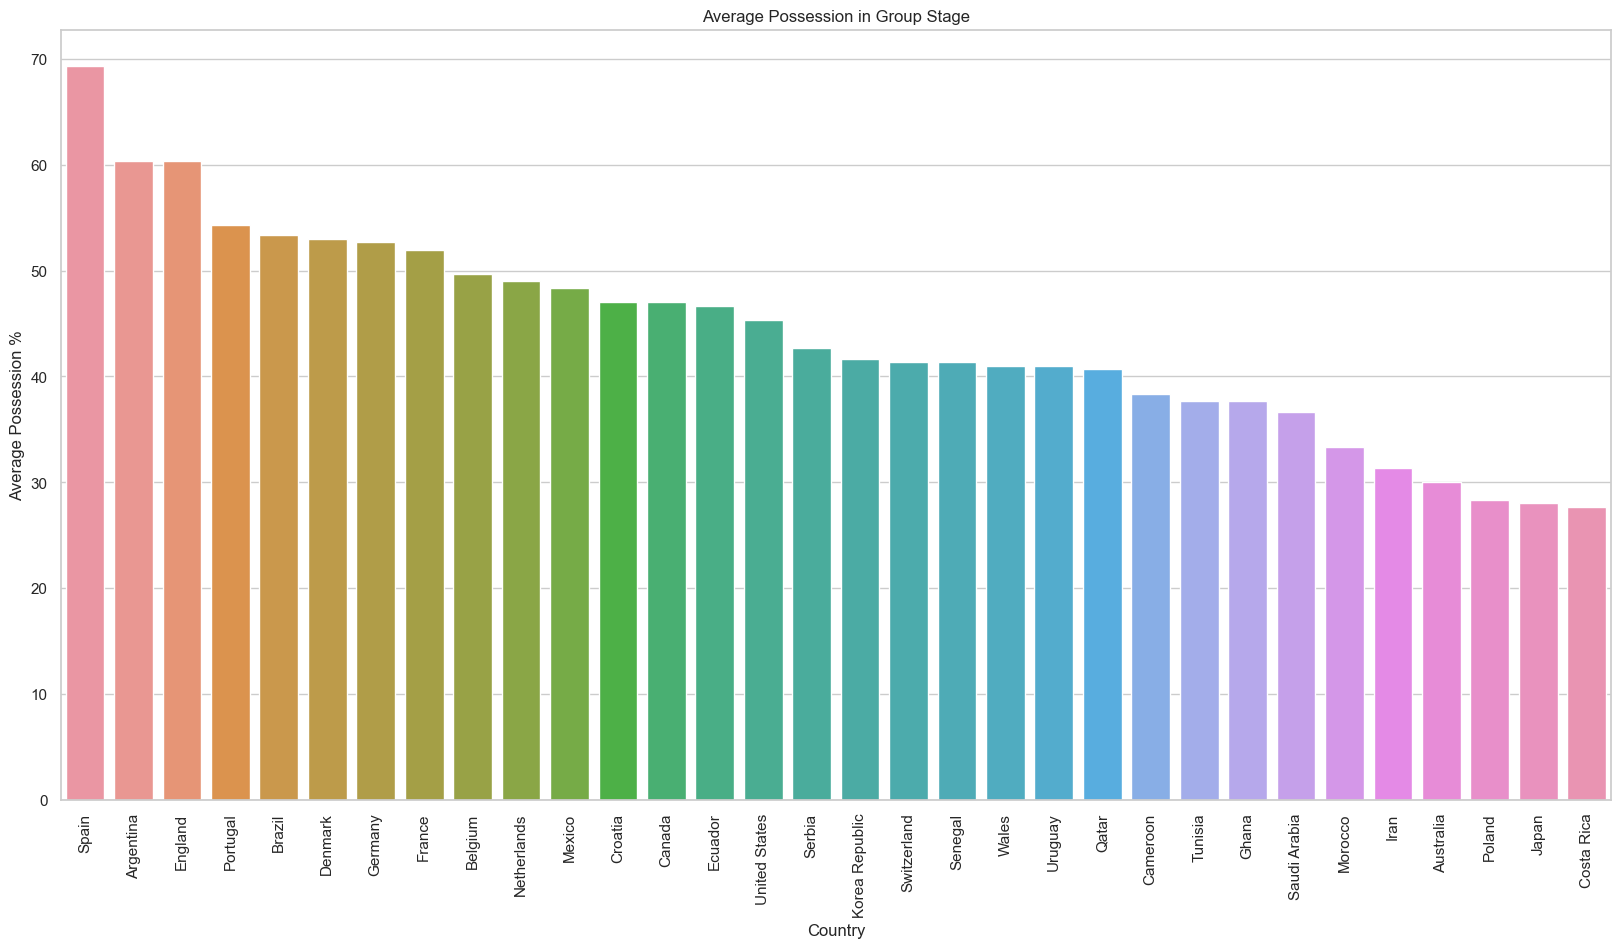

In [288]:
# i want this to be colored by groupid but for some reason it doesnt want to work...any ideas?
plt.figure(figsize=(20, 10))
sns.barplot(x=countries['Average Possession in Group'].sort_values(ascending=False).index, y=countries['Average Possession in Group'].sort_values(ascending=False))
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Average Possession %')
plt.title('Average Possession in Group Stage')
plt.show()